In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
import numpy as np
import pandas as pd

In [3]:
import datetime as dt
from datetime import datetime

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [5]:
engine = create_engine("sqlite:///Resources/hawaii.sqlite", echo=False)

In [6]:
# Importing and establishing Base for which classes will be constructed 
Base = automap_base()

In [7]:
# reflecting an existing database into a new model
# reflecting the tables
Base.prepare(engine, reflect=True)

In [8]:
# We can view all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [9]:
# Saving references to each table
m = Base.classes.measurement
s = Base.classes.station

In [10]:
# Creating our session (link) from Python to the DB
session = Session(engine)

# Exploratory Climate Analysis

In [11]:
# using the inspect function to check table names and column names 
inspector = inspect(engine)
inspector.get_table_names()

# measurement table columns
columns = inspector.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [12]:
#Printing first 5 rows of measurement table
for row in session.query(m.id, m.station,m.date,m.prcp,m.tobs).limit(5).all():
    print(row)

(1, 'USC00519397', '2010-01-01', 0.08, 65.0)
(2, 'USC00519397', '2010-01-02', 0.0, 63.0)
(3, 'USC00519397', '2010-01-03', 0.0, 74.0)
(4, 'USC00519397', '2010-01-04', 0.0, 76.0)
(5, 'USC00519397', '2010-01-06', None, 73.0)


In [13]:
# station table columns
columns = inspector.get_columns('station')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [14]:
# Printing first row of station table
first_row = session.query(s).first()
first_row.__dict__

{'_sa_instance_state': <sqlalchemy.orm.state.InstanceState at 0x217d450eb08>,
 'longitude': -157.8168,
 'id': 1,
 'name': 'WAIKIKI 717.2, HI US',
 'latitude': 21.2716,
 'station': 'USC00519397',
 'elevation': 3.0}

C:\Users\Abraham\anaconda3\envs\python31\lib\site-packages\pandas\plotting\_matplotlib\core.py:1235: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(xticklabels)


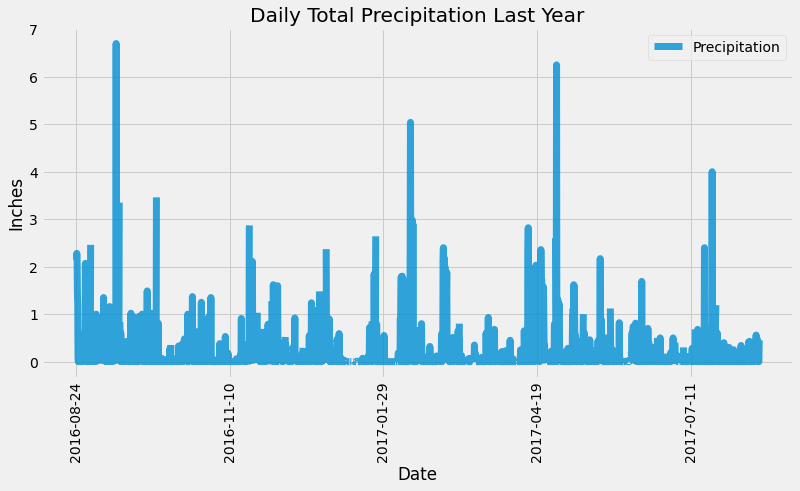

In [15]:
# Query to retrieve the last 12 months of precipitation data and plot the results

# Calculating the date 1 year ago from the last data point in the database
last_date = session.query(func.max(m.date)).first()
query_date = datetime.strptime(last_date[0], "%Y-%m-%d")
query_date = query_date - dt.timedelta(days=365)

# Performing a query to retrieve the data and precipitation scores
result = session.query(m.date, m.prcp).filter(m.date >= query_date).all()

# Saving the query results as a Pandas DataFrame and set the index to the date column
prcp_last_year = pd.DataFrame(result, columns=['date', 'Precipitation']).set_index('date')

# Sorting the dataframe by date
prcp_last_year = prcp_last_year.sort_values('date')

# Using Pandas Plotting with Matplotlib to plot the data
ax = prcp_last_year.plot(figsize=(12,6),
                         lw=7,
                         alpha=0.8
                         )
# Setting title and labels for axes
ax.set(xlabel="Date",
       ylabel="Inches",
       title="Daily Total Precipitation Last Year")
# Adding legend
ax.legend()
# Setting xaxis ticks rotation
ax.xaxis.set_tick_params(rotation=90)

# Saving the file
plt.savefig('Images/precipitation.png')
# Printing our chart to the screen
plt.show()

In [16]:
# Using Pandas to calcualte the summary statistics for the precipitation data
prcp_last_year['Precipitation'].describe()

count    2015.000000
mean        0.176462
std         0.460288
min         0.000000
25%         0.000000
50%         0.020000
75%         0.130000
max         6.700000
Name: Precipitation, dtype: float64

In [17]:
# Query to show how many stations are available in this dataset?
station_count = session.query(m).group_by(m.station).count()
print(f"Number of stations available is: {station_count}")

Number of stations available is: 9


In [18]:
# What are the most active stations? (i.e. what stations have the most rows)?
# Listing the stations and the counts in descending order.
station_list = session.query(m.station, s.name, func.count(m.station)) \
                      .filter(m.station == s.station) \
                      .group_by(m.station) \
                      .order_by(func.count(m.station).desc()).all()
station_list

[('USC00519281', 'WAIHEE 837.5, HI US', 2772),
 ('USC00519397', 'WAIKIKI 717.2, HI US', 2724),
 ('USC00513117', 'KANEOHE 838.1, HI US', 2709),
 ('USC00519523', 'WAIMANALO EXPERIMENTAL FARM, HI US', 2669),
 ('USC00516128', 'MANOA LYON ARBO 785.2, HI US', 2612),
 ('USC00514830', 'KUALOA RANCH HEADQUARTERS 886.9, HI US', 2202),
 ('USC00511918', 'HONOLULU OBSERVATORY 702.2, HI US', 1979),
 ('USC00517948', 'PEARL CITY, HI US', 1372),
 ('USC00518838', 'UPPER WAHIAWA 874.3, HI US', 511)]

In [19]:
# Using the station id from the previous query, calculate the lowest temperature recorded, 
# highest temperature recorded, and average temperature of the most active station?

# Choosing the station with the highest number of temperature observations.
active_station = station_list[0][0]

avg_temp = session.query(func.min(m.tobs),func.max(m.tobs),func.avg(m.tobs)) \
                      .filter(m.station == active_station).all()

print(f"Temperature observation data (TOBS) at Station {station_list[0][1]}\n \
        Lowest Temperature: {avg_temp[0][0]}\n \
        Highest Temperature: {avg_temp[0][1]}\n \
        Average Temperature: {round(avg_temp[0][2],2)}")

Temperature observation data (TOBS) at Station WAIHEE 837.5, HI US
         Lowest Temperature: 54.0
         Highest Temperature: 85.0
         Average Temperature: 71.66


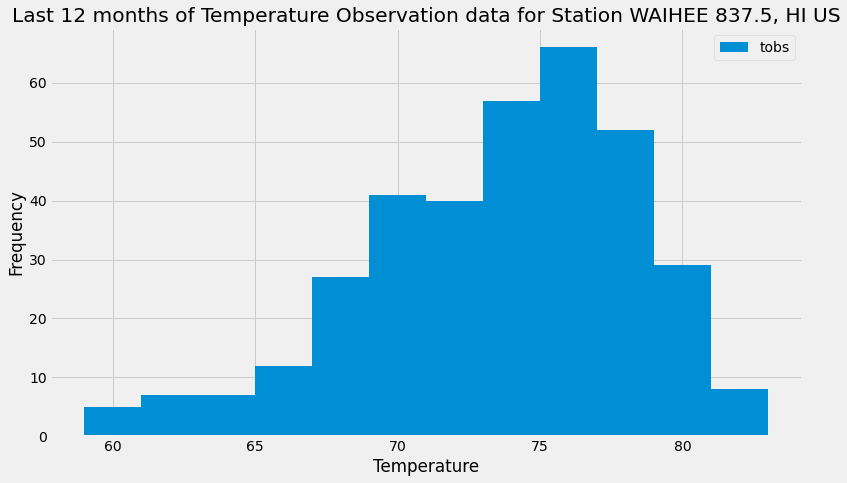

In [20]:
# Querying the last 12 months of temperature observation data for this station and plot the results as a histogram
stmt = session.query(m.tobs) \
                .filter(m.station == active_station)\
                .filter(m.date >= query_date).statement
active_station_tobs = pd.read_sql_query(stmt, session.bind)

# Ploting histogram
active_station_tobs.hist(bins=12,
                         label="tobs",
                         figsize=(12,7))


plt.title(f"Last 12 months of Temperature Observation data for Station {station_list[0][1]}")
plt.xlabel("Temperature")
plt.ylabel("Frequency")
plt.legend()
plt.savefig('Images/station-histogram.png')
plt.show()

## Bonus Challenge Assignment

In [21]:
# This function called `calc_temps` will accept start date and end date in the format '%Y-%m-%d' 
# and return the minimum, average, and maximum temperatures for that range of dates
def calc_temps(start_date, end_date):
    return session.query(func.min(m.tobs), func.avg(m.tobs), func.max(m.tobs)).\
            filter(m.date >= start_date).filter(m.date <= end_date).all()   


In [22]:
# Useing your previous function `calc_temps` to calculate the tmin, tavg, and tmax 
# for the trip using the previous year's data for those same dates.
trip_start_date = dt.date(2018,1,1)
trip_end_date = dt.date(2018,1,7)
last_yr_sdate = trip_start_date - dt.timedelta(days=365)
last_yr_edate = trip_end_date - dt.timedelta(days=365)

temp_data = calc_temps(last_yr_sdate,last_yr_edate)
TMIN = temp_data[0][0]
TAVG = round(temp_data[0][1],2)
TMAX = temp_data[0][2]

print(f"Trip planned from {trip_start_date} to {trip_end_date}\n")
print("Minimum, Average and Maximum Temperatures on last year same day is:\n")
print(f"Minimum: {TMIN}\nAverage: {TAVG}\nMaximum: {TMAX}")

Trip planned from 2018-01-01 to 2018-01-07

Minimum, Average and Maximum Temperatures on last year same day is:

Minimum: 62.0
Average: 68.37
Maximum: 74.0


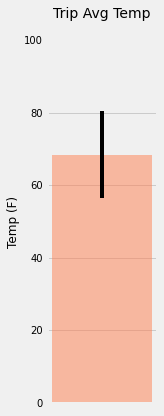

In [23]:
# Plotting the results from your previous query as a bar chart. 
# Using "Trip Avg Temp" as your Title
# Using the average temperature for the y value
# Using the peak-to-peak (tmax-tmin) value as the y error bar (yerr)
plt.figure(figsize=(2.5,6))
plt.bar(1,TAVG, color = 'coral',alpha = 0.5)
plt.errorbar(1,TAVG, yerr=(TMAX - TMIN), color = 'k')
plt.ylim(0, 100)
plt.xticks([])
plt.title('Trip Avg Temp\n', fontsize=14)
plt.ylabel("Temp (F)", fontsize=12)
plt.yticks(fontsize=10)
plt.tight_layout()
plt.savefig('Images/temperature.png')
plt.show()

In [24]:
# Calculating the total amount of rainfall per weather station for your trip dates using the previous year's matching dates.
# Sorting this in descending order by precipitation amount and list the station, name, latitude, longitude, and elevation
stmt = session.query(m.station, s.name, s.latitude,s.longitude,s.elevation,func.sum(m.prcp)) \
            .filter(m.station==s.station) \
            .filter(m.date >= last_yr_sdate) \
            .filter(m.date <= last_yr_edate) \
            .group_by(m.station) \
            .order_by(func.sum(m.prcp).desc()).statement
rainfall = pd.read_sql_query(stmt, session.bind)
rainfall = rainfall.rename(columns={"station":"Station_id",
                                    "name":"Station Name",
                                    "latitude":"Latitude",
                                    "longitude":"Longitude",
                                    "elevation":"Elevation",
                                    "sum_1":"Total Rainfall"})

print(f"Trip planned from {trip_start_date} to {trip_end_date}\n")
print (f"Last Year's Rainfall Per Weather Station")
rainfall

Trip planned from 2018-01-01 to 2018-01-07

Last Year's Rainfall Per Weather Station


,Station_id,Station Name,Latitude,Longitude,Elevation,Total Rainfall
0,USC00519523,"WAIMANALO EXPERIMENTAL FARM, HI US",21.33556,-157.71139,19.5,0.61
1,USC00516128,"MANOA LYON ARBO 785.2, HI US",21.33310,-157.80250,152.4,0.60
2,USC00514830,"KUALOA RANCH HEADQUARTERS 886.9, HI US",21.52130,-157.83740,7.0,0.60
3,USC00513117,"KANEOHE 838.1, HI US",21.42340,-157.80150,14.6,0.35
4,USC00519281,"WAIHEE 837.5, HI US",21.45167,-157.84889,32.9,0.20
5,USC00519397,"WAIKIKI 717.2, HI US",21.27160,-157.81680,3.0,0.00


In [25]:
# Creating a query that will calculate the daily normals 
# (i.e. the averages for tmin, tmax, and tavg for all historic data matching a specific month and day)

def daily_normals(date):
    sel = [func.min(m.tobs), func.avg(m.tobs), func.max(m.tobs)]
    return session.query(*sel).filter(func.strftime("%m-%d", m.date) == date).all()


In [26]:
# calculating the daily normals for your trip
# pushing each tuple of calculations into a list called `normals`
normals = []
# Using the start and end date to create a range of dates
trip_dates = pd.date_range(trip_start_date, trip_end_date)
# Stipping off the year and save a list of %m-%d strings
trip_dates_m_d = trip_dates.strftime('%m-%d')
# Looping through the list of %m-%d strings and calculate the normals for each date
for day in trip_dates_m_d:
    # call daily_normals function to return the tuple list
    temp = daily_normals(day)[0]
    normals.append(temp)
normals

[(62.0, 69.15384615384616, 77.0),
 (60.0, 69.39622641509433, 77.0),
 (62.0, 68.9090909090909, 77.0),
 (58.0, 70.0, 76.0),
 (56.0, 67.96428571428571, 76.0),
 (61.0, 68.96491228070175, 76.0),
 (57.0, 68.54385964912281, 76.0)]

In [27]:
# Loading the previous query results into a Pandas DataFrame and add the `trip_dates` range as the `date` index
normals_df = pd.DataFrame(normals, columns = ['tmin', 'tavg', 'tmax'])
normals_df['Date'] = trip_dates
normals_df.set_index('Date', inplace=True)
normals_df

,tmin,tavg,tmax
Date,,,
2018-01-01,62.0,69.153846,77.0
2018-01-02,60.0,69.396226,77.0
2018-01-03,62.0,68.909091,77.0
2018-01-04,58.0,70.000000,76.0
2018-01-05,56.0,67.964286,76.0
2018-01-06,61.0,68.964912,76.0
2018-01-07,57.0,68.543860,76.0


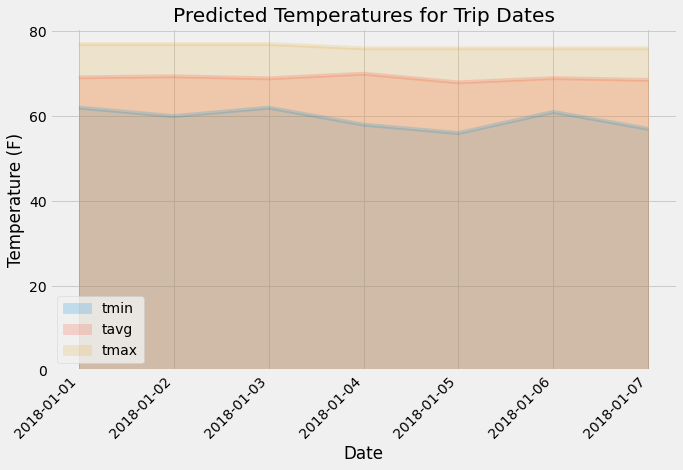

In [28]:
# Ploting the daily normals as an area plot with `stacked=False`
ax = normals_df.plot(kind='area',
                     stacked=False,
                     x_compat=True,
                     alpha=0.2,
                     figsize=(10,7))
# Setting title and labels for axes
ax.set(ylabel="Temperature (F)",
       title="Predicted Temperatures for Trip Dates")

# Setting xaxis ticks rotation
ax.xaxis.set_tick_params(rotation=45)
# Defining the date format
date_form = mdates.DateFormatter("%Y-%m-%d")
ax.xaxis.set_major_formatter(date_form)

y_ticks = np.arange(0, 90, 20)
plt.yticks(y_ticks)
plt.savefig('Images/daily_normals.png')
plt.show()